In [1]:
import os
import pandas as pd
import numpy as np
import csv
import networkx as nx
import matplotlib.pyplot as plt
import torch

## Drawing Utility

Takes in a undirected graph, and a color map, and draw the graph out in a circular format. 

In [2]:
from torch_geometric.utils import to_networkx

def draw_entry(entry):
    g = to_networkx(entry)
    label = entry["y"]
    
    # Create color map from selected nodes, green for selected, grey for unselected.
    color_map = ["grey"] * len(g.nodes)

    for i in np.flatnonzero(label):
        color_map[i] = "green"
        
    node_lables = nx.get_node_attributes(g, "weight")
    
    if node_lables:
        node_lables = {k: "{0}: {1}".format(k, v) for (k, v) in node_lables.items()}
    else:
        node_lables = {k: k for k in g.nodes}
    
    plt.figure()
    pos = nx.circular_layout(g)
    nx.draw(g, pos, node_size=2000, width = 1, node_color = color_map)
    nx.draw_networkx_labels(g, pos, node_lables)
    plt.show()  
    # plt.savefig("graph.png", dpi=1000)


In [4]:
dataset_name = "binomial_80"
root_dir = "data/" + dataset_name
label_filename = "label.csv"

# Read CSV File
label_arr = []
with open(os.path.join(root_dir, label_filename), 'r') as label_file:
    label_reader = csv.reader(label_file, delimiter = ",")
    for row in label_reader:
        label_arr.append([row[0]] + sorted(row[1:]))
label_frame = pd.DataFrame(data=label_arr)
label_frame.head()

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,Filename,0,1,10,11,12,13,14,15,16,...,72,73,74,75,76,77,78,79,8,9
1,binomial0.txt,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,binomial1.txt,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,binomial2.txt,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,binomial3.txt,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [5]:
import torch
from torch_geometric.data import InMemoryDataset, DataLoader
from torch_geometric.utils import from_networkx

class MaxIndSetDataset(InMemoryDataset):
    """Graphs labelled with its Maximum Independent Set"""
    
    def __init__(self, csv_file = None, root_dir = None, tar_dir = None):
        if csv_file and root_dir:
            # Read CSV File
            label_arr = []
            with open(os.path.join(root_dir, label_filename), 'r') as label_file:
                label_reader = csv.reader(label_file, delimiter = ",")
                for row in label_reader:
                    label_arr.append([row[0]] + sorted(row[1:]))
            self.label_frame = pd.DataFrame(data=label_arr)
            self.root_dir = root_dir
            self.transform = None
        else:
            raise NotImplementedError("Need to supply csv_file and root_dir")
    def __len__(self):
        return len(self.label_frame)
    
    def get(self, idx):
        graph_name = os.path.join(self.root_dir, self.label_frame.iloc[idx, 0])
        graph = nx.read_adjlist(graph_name, nodetype=int)
        label_array = np.array(self.label_frame.iloc[idx, 1:].dropna(), dtype=np.int)
        
        # A binary vector of the nodes used
        label_bin = np.zeros(len(graph.nodes))
        label_bin[label_array] = 1
        
        sample = {"graph": graph, "label": label_bin}
        
        # 
        data = from_networkx(sample["graph"])
        data.y = torch.tensor(sample["label"], dtype=torch.int64) # Use pytorch tensor
        return data

In [11]:
generic_bin_dataset = MaxIndSetDataset(csv_file='data/test/label.csv', 
                                       root_dir='data/test/')


In [12]:
len(generic_bin_dataset)

101

In [13]:
train_loader = DataLoader(generic_bin_dataset[:10], batch_size=1, shuffle=True)
val_loader = DataLoader(generic_bin_dataset[10:15], batch_size=1)
test_loader = DataLoader(generic_bin_dataset[15:], batch_size=2)

FileNotFoundError: [Errno 2] No such file or directory: 'data/test/Filename'

In [33]:
for i, batch in enumerate(test_loader):
    print(i)
    print(batch["edge_index"])
    if i >= 0:
        break

0
tensor([[ 0,  2,  2,  2,  2,  1,  1,  1,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,
          5,  5,  5,  5,  5,  5,  6,  6,  7,  7,  7,  7,  7,  9,  9,  9,  8,  8,
          8,  8, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 15, 15,
         15, 15, 18, 18, 18, 18, 18, 18, 14, 14, 14, 14, 14, 14, 17, 17, 17, 17,
         13, 13, 16, 16, 19, 19],
        [ 2,  0,  6,  7,  9,  3,  4,  5,  1,  4,  5,  8,  9,  1,  3,  5,  7,  8,
          1,  3,  4,  6,  7,  8,  2,  5,  2,  4,  5,  8,  9,  2,  3,  7,  3,  4,
          5,  7, 11, 12, 15, 18, 10, 14, 15, 17, 18, 10, 13, 16, 17, 18, 10, 11,
         14, 18, 10, 11, 12, 14, 15, 17, 11, 13, 15, 16, 18, 19, 11, 12, 18, 19,
         12, 14, 12, 14, 14, 17]])


## Sample Network

Version 1: No node weights, only maximizing cardinality

In [99]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, data):
        node_weights = data["weight"]
        edge_index = data["edge_index"]
        x = self.conv1(node_weights, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.sigmoid(x)
        return x

In [102]:
from tqdm import tqdm

### Runs but losses dont go down, seems to converge to around 0.48

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net().to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in tqdm(range(30)):
    running_loss = 0.0
    
    for i, item in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        
        item["weight"] = torch.ones([len(item["y"])]).reshape(-1, 1)
        item = item.to(device)
        outputs = model(item)

        loss = criterion(outputs.squeeze(), item["y"].float().squeeze())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 20 == 19:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.6f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0
print('Finished Training')        
        
        

  0%|          | 0/30 [00:00<?, ?it/s]

[1,    20] loss: 0.587476
[1,    40] loss: 0.495851
[1,    60] loss: 0.494225
[1,    80] loss: 0.492661
[1,   100] loss: 0.493237
[1,   120] loss: 0.491927


  3%|▎         | 1/30 [00:40<19:39, 40.68s/it]

[2,    20] loss: 0.492598
[2,    40] loss: 0.492883
[2,    60] loss: 0.491546
[2,    80] loss: 0.491427
[2,   100] loss: 0.489973
[2,   120] loss: 0.491368


  7%|▋         | 2/30 [01:21<18:59, 40.69s/it]

[3,    20] loss: 0.489902
[3,    40] loss: 0.489059
[3,    60] loss: 0.489847
[3,    80] loss: 0.488403
[3,   100] loss: 0.488511
[3,   120] loss: 0.488344


 10%|█         | 3/30 [02:02<18:22, 40.83s/it]

[4,    20] loss: 0.487499
[4,    40] loss: 0.486581
[4,    60] loss: 0.486605
[4,    80] loss: 0.486135
[4,   100] loss: 0.486228
[4,   120] loss: 0.484303


 13%|█▎        | 4/30 [02:43<17:41, 40.82s/it]

[5,    20] loss: 0.484138
[5,    40] loss: 0.483576
[5,    60] loss: 0.483359
[5,    80] loss: 0.482669
[5,   100] loss: 0.482071
[5,   120] loss: 0.482566


 17%|█▋        | 5/30 [03:24<17:00, 40.81s/it]

[6,    20] loss: 0.481892
[6,    40] loss: 0.480311
[6,    60] loss: 0.480448
[6,    80] loss: 0.480134
[6,   100] loss: 0.479383
[6,   120] loss: 0.479381


 20%|██        | 6/30 [04:05<16:19, 40.83s/it]

[7,    20] loss: 0.478363
[7,    40] loss: 0.478845
[7,    60] loss: 0.477381
[7,    80] loss: 0.478148
[7,   100] loss: 0.476133
[7,   120] loss: 0.476202


 23%|██▎       | 7/30 [04:45<15:39, 40.83s/it]

[8,    20] loss: 0.476948
[8,    40] loss: 0.474744
[8,    60] loss: 0.474684
[8,    80] loss: 0.474681
[8,   100] loss: 0.474427
[8,   120] loss: 0.474648


 27%|██▋       | 8/30 [05:26<14:58, 40.84s/it]

[9,    20] loss: 0.474349
[9,    40] loss: 0.473253
[9,    60] loss: 0.473096
[9,    80] loss: 0.472627
[9,   100] loss: 0.472046
[9,   120] loss: 0.472068


 30%|███       | 9/30 [06:07<14:17, 40.85s/it]

[10,    20] loss: 0.470985
[10,    40] loss: 0.470836
[10,    60] loss: 0.470756
[10,    80] loss: 0.471735
[10,   100] loss: 0.470583
[10,   120] loss: 0.470722


 33%|███▎      | 10/30 [06:48<13:37, 40.86s/it]

[11,    20] loss: 0.470187
[11,    40] loss: 0.469972
[11,    60] loss: 0.469659
[11,    80] loss: 0.469205
[11,   100] loss: 0.469049
[11,   120] loss: 0.468734


 37%|███▋      | 11/30 [07:29<12:57, 40.92s/it]

[12,    20] loss: 0.469315
[12,    40] loss: 0.468667
[12,    60] loss: 0.468360
[12,    80] loss: 0.467396
[12,   100] loss: 0.467091
[12,   120] loss: 0.467895


 40%|████      | 12/30 [08:10<12:16, 40.91s/it]

[13,    20] loss: 0.468021
[13,    40] loss: 0.467780
[13,    60] loss: 0.465839
[13,    80] loss: 0.467160
[13,   100] loss: 0.466716
[13,   120] loss: 0.466955


 43%|████▎     | 13/30 [08:51<11:36, 40.97s/it]

[14,    20] loss: 0.466797
[14,    40] loss: 0.466201
[14,    60] loss: 0.465624
[14,    80] loss: 0.466886
[14,   100] loss: 0.466497
[14,   120] loss: 0.466237


 47%|████▋     | 14/30 [09:32<10:55, 40.95s/it]

[15,    20] loss: 0.465637
[15,    40] loss: 0.466099
[15,    60] loss: 0.464824
[15,    80] loss: 0.466182
[15,   100] loss: 0.466077
[15,   120] loss: 0.464073


 50%|█████     | 15/30 [10:13<10:13, 40.92s/it]

[16,    20] loss: 0.465308
[16,    40] loss: 0.464681
[16,    60] loss: 0.464702
[16,    80] loss: 0.465601
[16,   100] loss: 0.465150
[16,   120] loss: 0.464874


 53%|█████▎    | 16/30 [10:54<09:32, 40.90s/it]

[17,    20] loss: 0.464998
[17,    40] loss: 0.464512
[17,    60] loss: 0.463986
[17,    80] loss: 0.464365
[17,   100] loss: 0.464555
[17,   120] loss: 0.464254


 57%|█████▋    | 17/30 [11:35<08:52, 40.93s/it]

[18,    20] loss: 0.464540
[18,    40] loss: 0.465254
[18,    60] loss: 0.464495
[18,    80] loss: 0.462975
[18,   100] loss: 0.464687
[18,   120] loss: 0.463246


 60%|██████    | 18/30 [12:16<08:11, 40.94s/it]

[19,    20] loss: 0.463887
[19,    40] loss: 0.463426
[19,    60] loss: 0.464606
[19,    80] loss: 0.463245
[19,   100] loss: 0.464012
[19,   120] loss: 0.463777


 63%|██████▎   | 19/30 [12:57<07:30, 40.96s/it]

[20,    20] loss: 0.463117
[20,    40] loss: 0.464208
[20,    60] loss: 0.463431
[20,    80] loss: 0.464196
[20,   100] loss: 0.463058
[20,   120] loss: 0.464243


 67%|██████▋   | 20/30 [13:38<06:50, 41.01s/it]

[21,    20] loss: 0.464065
[21,    40] loss: 0.463875
[21,    60] loss: 0.463098
[21,    80] loss: 0.464049
[21,   100] loss: 0.462981
[21,   120] loss: 0.462792


 70%|███████   | 21/30 [14:19<06:09, 41.00s/it]

[22,    20] loss: 0.464814
[22,    40] loss: 0.461996
[22,    60] loss: 0.463242
[22,    80] loss: 0.462389
[22,   100] loss: 0.463684
[22,   120] loss: 0.463612


 73%|███████▎  | 22/30 [15:00<05:27, 40.95s/it]

[23,    20] loss: 0.462990
[23,    40] loss: 0.462384
[23,    60] loss: 0.463313
[23,    80] loss: 0.463394
[23,   100] loss: 0.463345
[23,   120] loss: 0.463834


 77%|███████▋  | 23/30 [15:41<04:46, 41.00s/it]

[24,    20] loss: 0.463169
[24,    40] loss: 0.461703
[24,    60] loss: 0.462867
[24,    80] loss: 0.464063
[24,   100] loss: 0.462596
[24,   120] loss: 0.463731


 80%|████████  | 24/30 [16:22<04:05, 40.97s/it]

[25,    20] loss: 0.462289
[25,    40] loss: 0.462324
[25,    60] loss: 0.464160
[25,    80] loss: 0.463028
[25,   100] loss: 0.463287
[25,   120] loss: 0.462705


 83%|████████▎ | 25/30 [17:03<03:24, 41.00s/it]

[26,    20] loss: 0.462705
[26,    40] loss: 0.461034
[26,    60] loss: 0.464582
[26,    80] loss: 0.464715
[26,   100] loss: 0.462790
[26,   120] loss: 0.463299


 87%|████████▋ | 26/30 [17:43<02:43, 40.96s/it]

[27,    20] loss: 0.462452
[27,    40] loss: 0.462469
[27,    60] loss: 0.463332
[27,    80] loss: 0.462122
[27,   100] loss: 0.463367
[27,   120] loss: 0.463965


 90%|█████████ | 27/30 [18:24<02:02, 40.96s/it]

[28,    20] loss: 0.461952
[28,    40] loss: 0.462596
[28,    60] loss: 0.464357
[28,    80] loss: 0.462685
[28,   100] loss: 0.463025
[28,   120] loss: 0.463019


 93%|█████████▎| 28/30 [19:06<01:22, 41.01s/it]

[29,    20] loss: 0.463303
[29,    40] loss: 0.462146
[29,    60] loss: 0.462923
[29,    80] loss: 0.463726
[29,   100] loss: 0.462930
[29,   120] loss: 0.462754


 97%|█████████▋| 29/30 [19:47<00:41, 41.01s/it]

[30,    20] loss: 0.462212
[30,    40] loss: 0.462242
[30,    60] loss: 0.463721
[30,    80] loss: 0.463264
[30,   100] loss: 0.463082
[30,   120] loss: 0.463243


100%|██████████| 30/30 [20:27<00:00, 40.98s/it]

Finished Training


In [ ]:
### NOT Finished: Trying to implement an accuracy logger
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train(epoch):
    model.train()
    
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out, attn_loss, _ = model(data)
        loss = ((out - data.y).pow(2) + 100 * attn_loss).mean()
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()

    return total_loss / len(train_loader.dataset)


def test(loader):
    model.eval()

    corrects, total_ratio = [], 0
    for data in loader:
        data = data.to(device)
        out, _, ratio = model(data)
        pred = out.round().to(torch.long)
        corrects.append(pred.eq(data.y.to(torch.long)))
        total_ratio += ratio
    return torch.cat(corrects, dim=0), total_ratio / len(loader)


In [103]:
test_dataset = MaxIndSetDataset(csv_file='data/small_test/label.csv', 
                                       root_dir='data/small_test/')

In [110]:
ex = test_dataset[20]
ex

Data(edge_index=[2, 46], y=[10])

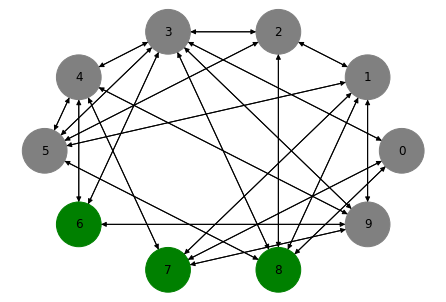

In [111]:
draw_entry(ex)

In [112]:
ex["weight"] = torch.ones([len(ex["y"])]).reshape(-1, 1)
ex.to(device)

Data(edge_index=[2, 46], weight=[10, 1], y=[10])

In [113]:
out = model(ex)
out

tensor([[0.3270],
        [0.1480],
        [0.2836],
        [0.0545],
        [0.1526],
        [0.1963],
        [0.3578],
        [0.1889],
        [0.1491],
        [0.1555]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [114]:
ans = out.detach().cpu().numpy().T.argsort()
ans

array([[3, 1, 8, 4, 9, 7, 5, 2, 0, 6]])

In [115]:
np.flip(ans)

array([[6, 0, 2, 5, 7, 9, 4, 8, 1, 3]])